### <font color=#3ede8e>What is a convolutional autoencoder?</font>
A convolutional autoencoder is a type of neural network architecture that combines convolutional layers and autoencoder principles to learn efficient representations of input data. It is commonly used for unsupervised learning tasks like image denoising, inpainting, or dimensionality reduction.
<br>

### <font color=#3ede8e>The steps to training a convolutional autoencoder:</font>


1.   Importing libraries
2.   Loading and preprocessing data<br>
Used FastAI `DataLoaders` object to preprocess and load data
3.  Creating the autoencoder model<br>
Defined the autoencoder model architecture by defining the encoder and decoder parts seperately
4.  Creating the learner<br>
Instantiated the fastai `Learner` object with our model, data loaders, an appropriate loss function, an optimizer and callback. In this case, we used the Mean Squared Error (MSE) loss to measure the reconstruction error and Adam optimizer.
5.  Training the autoencoder<br>
Trained the autoencoder model using the fastai `fit` method and saved the model afterwards.
6.  Inference and testing the model<br>
Loaded the saved model and tested it on dog images and plotted the results
7.  Dimensionality reduction<br>
Used UMAP and sklearn's TSNE to reduce the dimensions of the embeddings and visualized the results
8.  Training clustering models on the autoencoder's embeddings<br>
Used sklearn's `SpectralClustering` and `NearestNeighbors` to train two clustering models on the autoencoder's embeddings.




In [ ]:
%%capture
!pip install fastai==2.7.9
!pip install torch==1.12.1
!pip install graphviz
!pip install torchview
!pip install umap-learn

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Importing Libraries

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import torch
from torch import nn

from fastai.vision.all import *

import matplotlib.pyplot as plt
import seaborn as sns

from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

import umap

In [ ]:
# Change if necessary
class config:
  BASE_DIR = Path("/content/drive/MyDrive/Dog Image Generation")
  DATA_DIR = BASE_DIR / "data"
  MODEL_DIR = BASE_DIR / "models"

  IMG_SIZE = 128
  BS = 256 # Used 256 for batch size for faster trainig, 64 took so long to train in colab

# Loading and preprocessing data

In [ ]:
#A function for getting a Fastai dataloader object
def get_dls(source, img_size, bs):

    image_db = DataBlock(
                blocks=(ImageBlock, ImageBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.1, seed=2023), # Holding out 10 percent of data for validation
                item_tfms=Resize(img_size, ResizeMethod.Squish), # Did not augment images since this much data is  already sufficient
                batch_tfms=[Normalize()] # Normalize pixel values between 0 - 1
               )
    dls = image_db.dataloaders(source, bs=bs)
    return dls

In [ ]:
# Instantiate a FastAI dataloader object
dls = get_dls(config.DATA_DIR / "Images", config.IMG_SIZE, config.BS)

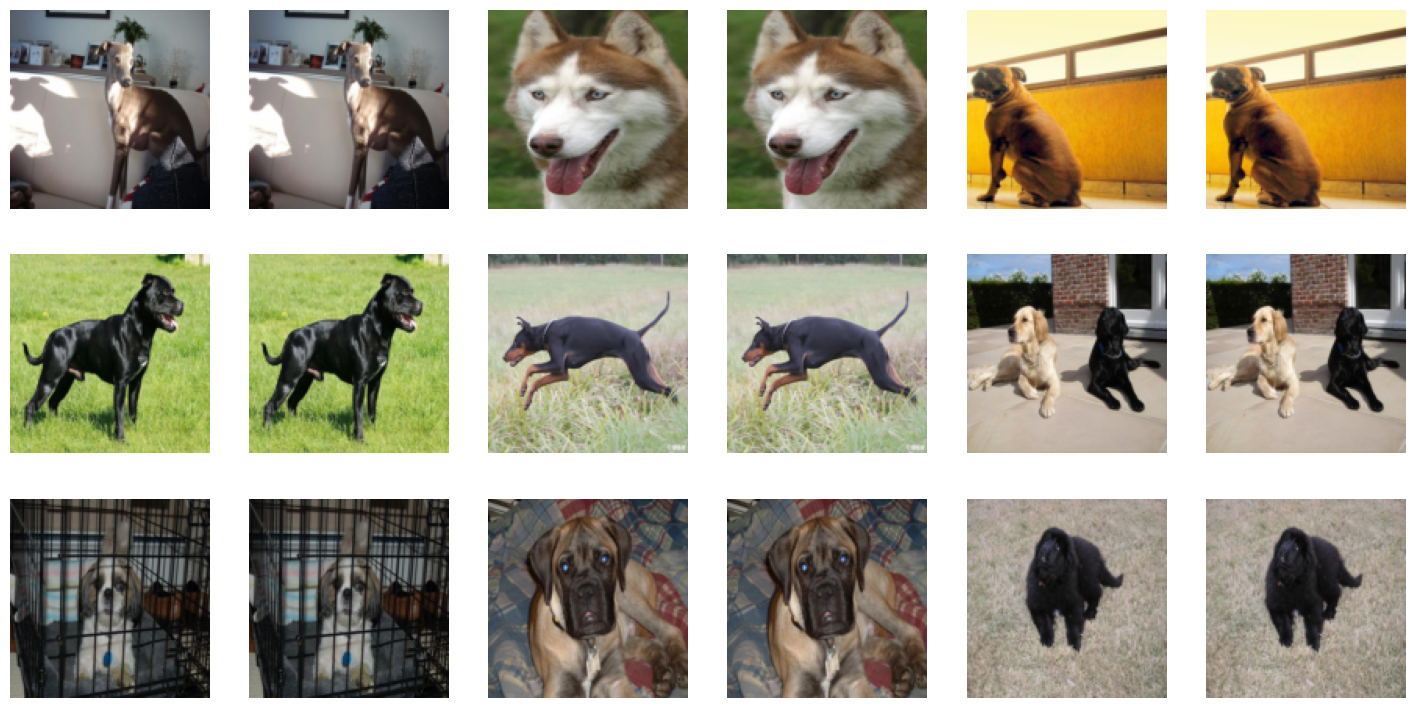

In [ ]:
# left image = input(X), right image = target(y)
dls.show_batch()

# Creating the autoencoder model

## <font color=#3ede8e>What are padding and stride?</font>
Both padding and stride play crucial roles in determining the architecture and behavior of convolutional neural networks. They influence the spatial dimensions of the feature maps, the receptive field sizes, and the amount of information being processed. Proper selection of padding and stride values depends on the specific task, size of the input, desired output, and the architecture of the network.
### <font color=#f08da4>Padding:</font>
Padding is the process of adding extra pixels to the input image before performing convolution. It helps to preserve spatial information by maintaining the dimensions of the input volume during convolution operations. Padding is typically done by adding zeros around the borders of the input image.
The main role of padding is to overcome a reduction in spatial dimensions caused by convolutional layers. Without padding, as the filter window moves across the input image, the output feature map size gradually reduces. Padding allows the output feature map size to be the same or larger than the input size.

Padding has two common options:
- Valid Padding (no padding): In this case, no padding is added to the input image, resulting in a reduction in spatial dimensions in each convolutional layer. This can be useful when downsampling the input to capture large-scale features.
- Same Padding: Same padding adds enough zeros to the input image such that the output size matches the input size. It helps maintain spatial dimensions and is commonly used when spatial information is critical, especially in early layers of convolutional networks.

### <font color=#f08da4>Stride:</font>
Stride determines the step size of the filter/kernel as it moves over the input image during convolution. It specifies the distance between the receptive fields applied at consecutive positions. When a stride greater than 1 is used, the filter skips some locations, resulting in a reduction of spatial dimensions in the output feature maps.

The main role of stride is twofold:
- Control Output Size: By adjusting the stride value, we can control the size of the output volume. A larger stride leads to a decrease in spatial dimensions, while a smaller stride results in smaller receptive fields and a higher resolution output.
- Reduce Computational Cost: Using a larger stride reduces the number of computations required in each convolutional operation, leading to faster computation and lower memory requirements. However, this comes at the cost of information loss due to the skipped locations.

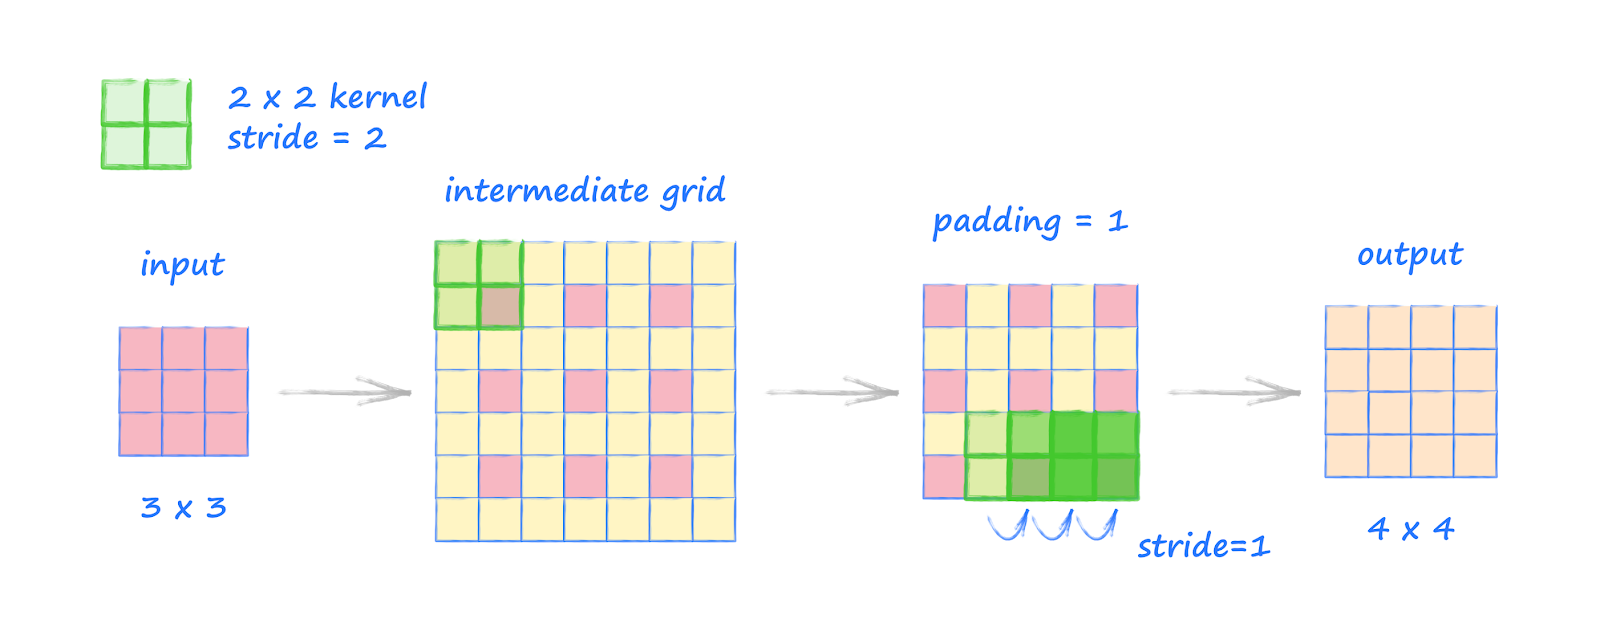



---
### <font color=#3ede8e>What is a Conv2DTranspose layer?</font>
A Conv2DTranspose layer, also known as a deconvolutional layer or a transposed convolutional layer, is used in convolutional autoencoders for the process of upsampling or decoding.

In a convolutional autoencoder, the encoding part reduces the spatial dimensions of the input data, while the decoding part reconstructs the original input from the encoded representation. The Conv2DTranspose layer helps in achieving this reconstruction step by performing an inverse operation of a convolutional layer.

Instead of downsampling the input volume, as convolutional layers do, the Conv2DTranspose layer performs an upsampling operation. It takes an input volume of lower spatial dimensions and produces an output volume of higher spatial dimensions. This is done by reversing the process of a regular convolution, where the input is convolved with a set of filters and then expanded to get a larger output.

Conv2DTranspose layers help in recovering the spatial information lost during the encoding process, allowing the autoencoder to learn a meaningful reconstruction of the original input.


In [ ]:
# Define model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
            )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 128, 5, stride=1, padding=2), # Pytorch does not support 'same' padding in ConvTranspose2d so we calculated manually
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, 4, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample((128, 128), mode='nearest'),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1)
            )
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
#Instantiating the model
model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=131072, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=131072, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (5): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): R

In [ ]:
# Visualize autoencoder architecture
model_graph = draw_graph(model,
                         input_size=(config.BS, 3, config.IMG_SIZE, config.IMG_SIZE),
                        #  graph_dir='LR',
                         expand_nested=True,
                         device='cuda',
                         save_graph=True,
                         filename='cae')
model_graph.resize_graph(4, 0.1, 6)
model_graph.visual_graph

# Creating the learner

In [ ]:
# Defining Callback to save the model with lowest validation loss duraing training
cbs = SaveModelCallback(monitor='valid_loss')
# Defining FastAI Learner object
learn = Learner(dls, model, loss_func=MSELossFlat(), opt_func=Adam, cbs=cbs) # MSE loss and Adam optimizer

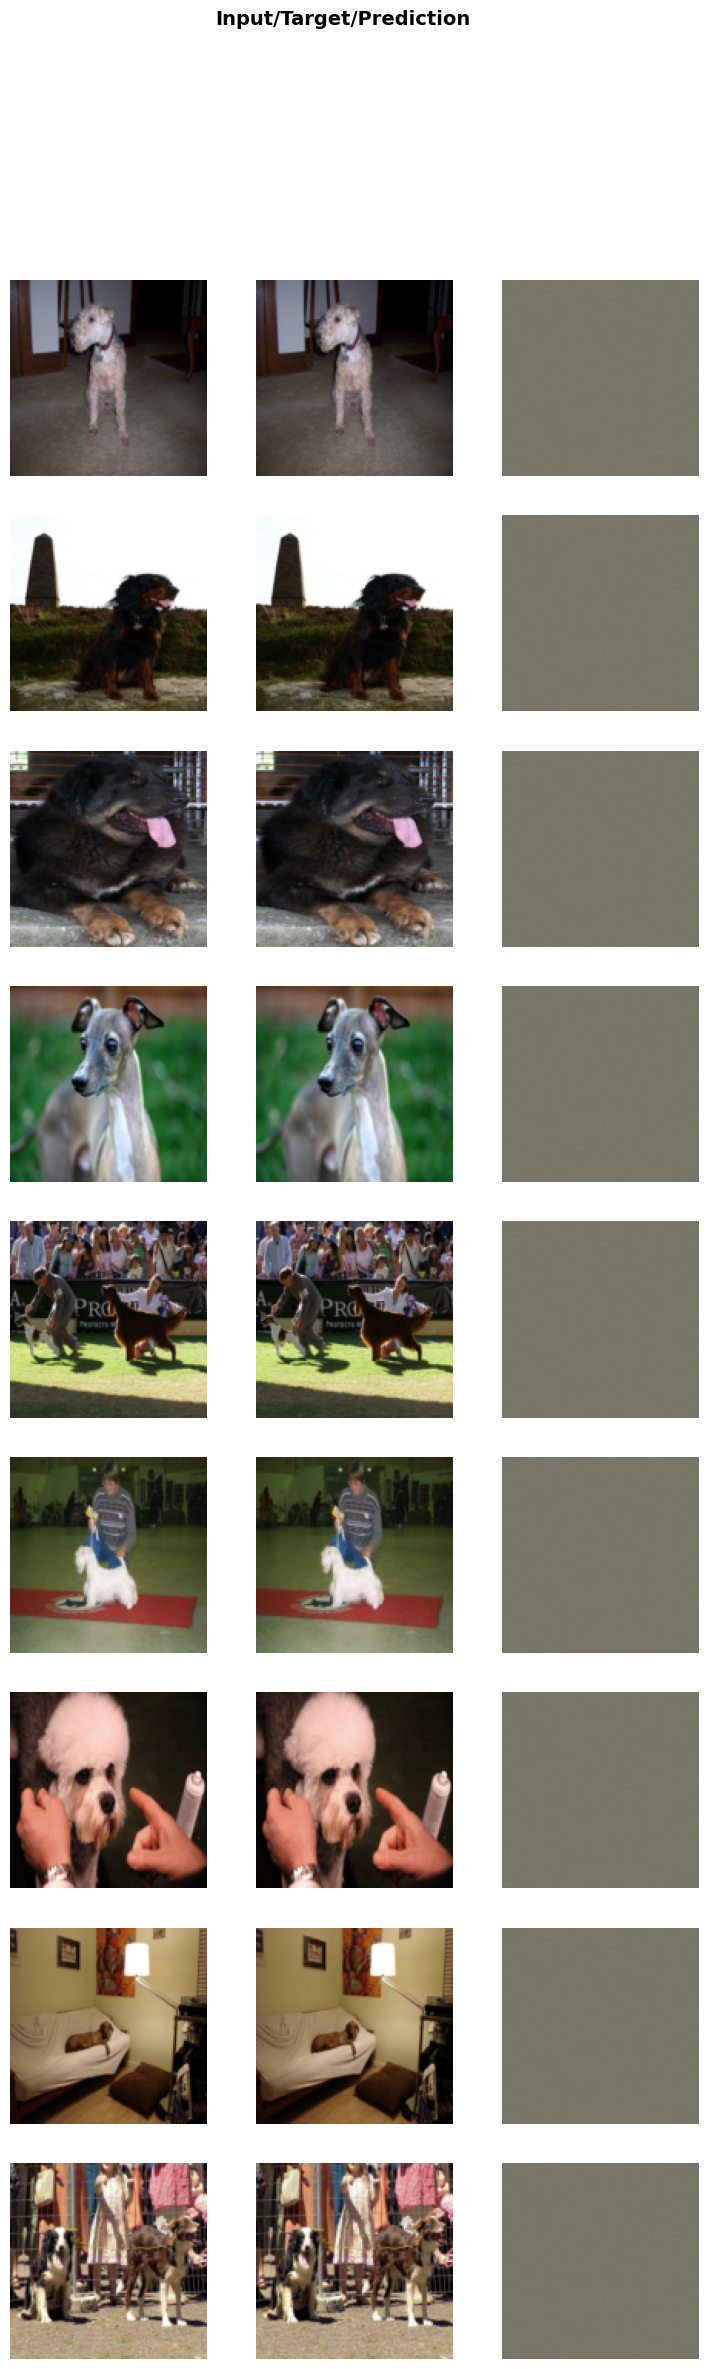

In [ ]:
# Model results before training
learn.show_results()

SuggestedLRs(valley=0.0008317637839354575)

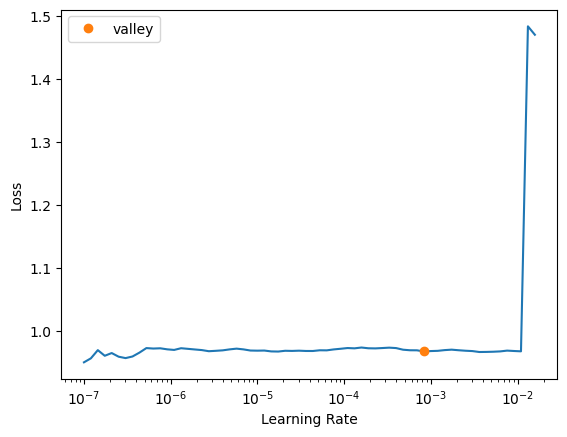

In [ ]:
# Test on one batch to find the optimal LR
learn.lr_find()

In [ ]:
# FastAI uses cosine annealing to decrease LR as the model progresses
# We found an optimal LR and trained for 15 epochs
learn.fit_one_cycle(n_epoch=15, lr_max=4e-4)

Better model found at epoch 0 with valid_loss value: 0.9041630625724792.
Better model found at epoch 1 with valid_loss value: 0.5333870053291321.
Better model found at epoch 2 with valid_loss value: 0.44500184059143066.
Better model found at epoch 3 with valid_loss value: 0.3967050313949585.
Better model found at epoch 4 with valid_loss value: 0.3708697557449341.
Better model found at epoch 5 with valid_loss value: 0.3538368046283722.
Better model found at epoch 6 with valid_loss value: 0.34404659271240234.
Better model found at epoch 7 with valid_loss value: 0.33296921849250793.
Better model found at epoch 8 with valid_loss value: 0.33156415820121765.
Better model found at epoch 9 with valid_loss value: 0.3149491846561432.
Better model found at epoch 10 with valid_loss value: 0.30059707164764404.
Better model found at epoch 11 with valid_loss value: 0.2936226427555084.
Better model found at epoch 12 with valid_loss value: 0.28991255164146423.
Better model found at epoch 13 with valid_

Better model found at epoch 14 with valid_loss value: 0.2877258062362671.


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

SuggestedLRs(valley=1.4454397387453355e-05)

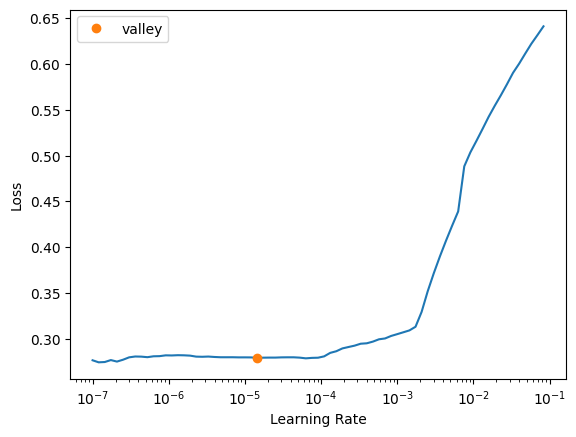

In [ ]:
# Test on one batch to find the optimal LR
learn.lr_find()

In [ ]:
learn.fit_one_cycle(n_epoch=15, lr_max=5e-5)

Better model found at epoch 0 with valid_loss value: 0.27614539861679077.
Better model found at epoch 2 with valid_loss value: 0.2751995027065277.
Better model found at epoch 3 with valid_loss value: 0.27216243743896484.
Better model found at epoch 4 with valid_loss value: 0.27128294110298157.
Better model found at epoch 5 with valid_loss value: 0.2687112092971802.
Better model found at epoch 6 with valid_loss value: 0.2671627104282379.
Better model found at epoch 7 with valid_loss value: 0.26588723063468933.
Better model found at epoch 8 with valid_loss value: 0.2645411193370819.
Better model found at epoch 9 with valid_loss value: 0.2635558843612671.
Better model found at epoch 10 with valid_loss value: 0.262751042842865.
Better model found at epoch 11 with valid_loss value: 0.26206859946250916.
Better model found at epoch 12 with valid_loss value: 0.2615901231765747.
Better model found at epoch 13 with valid_loss value: 0.26141157746315.
Better model found at epoch 14 with valid_los

In [ ]:
# Saving trained model
learn.export(config.MODEL_DIR / 'Dog_CAE_v3.pkl')

In [ ]:
# Loading saved model
learn = load_learner(config.MODEL_DIR / 'Dog_CAE_v3.pkl')
learn.dls = dls

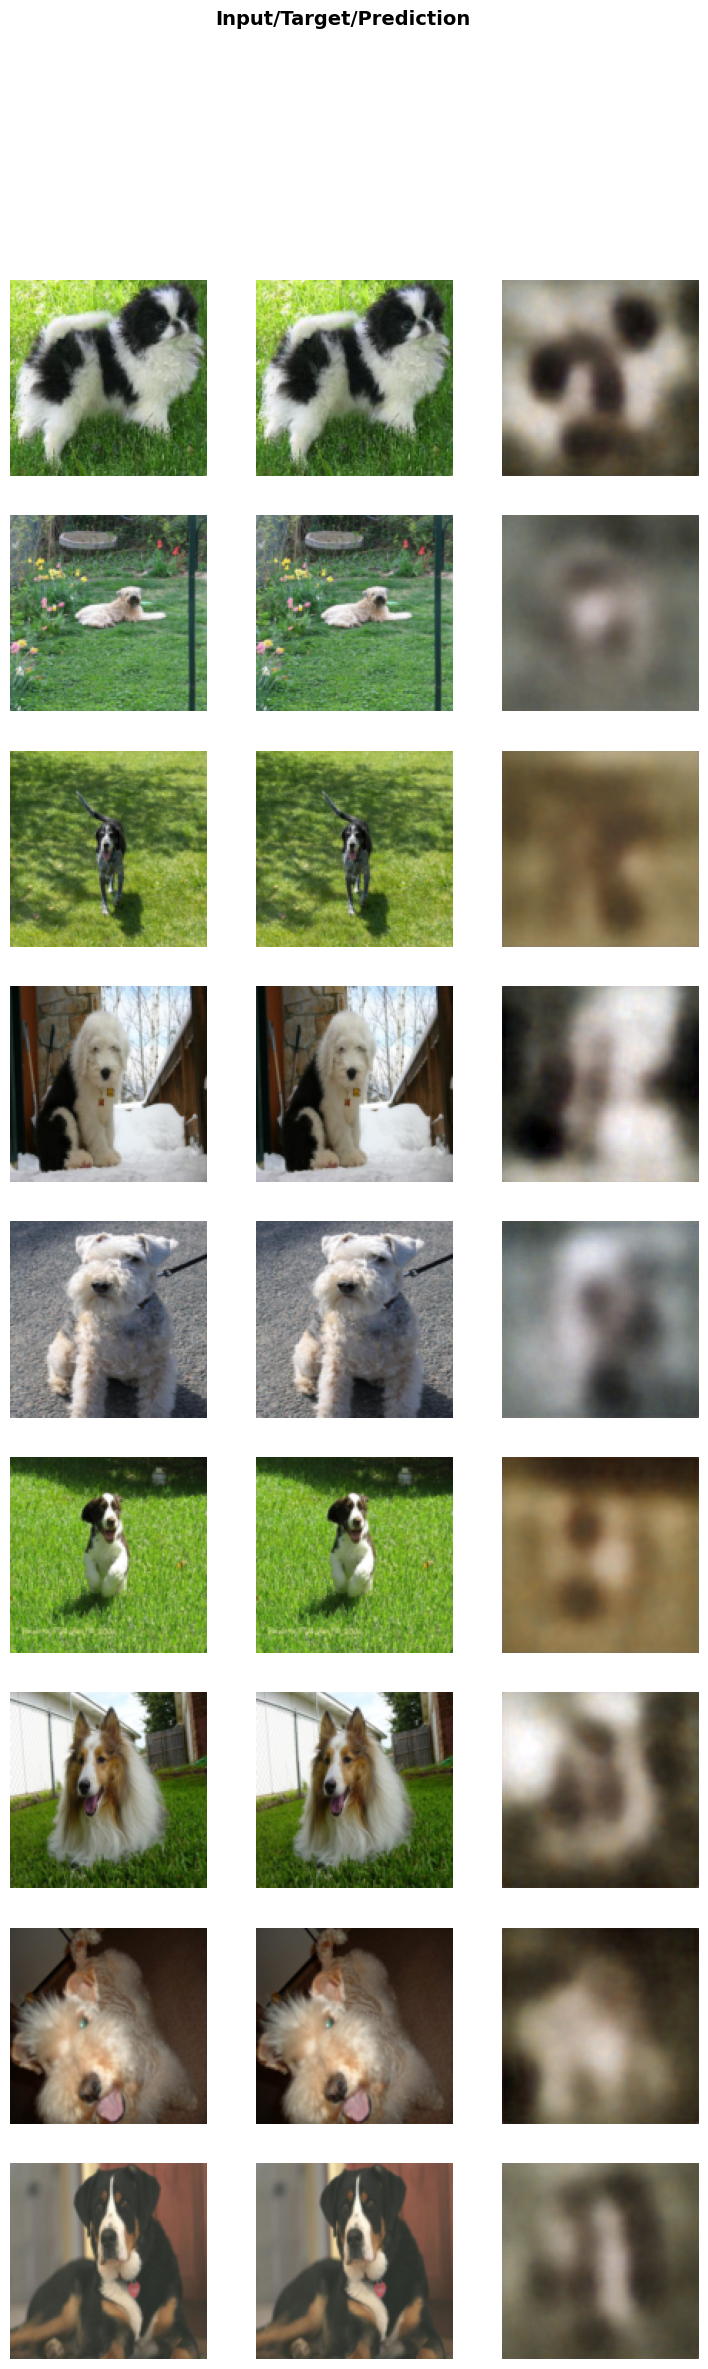

In [ ]:
# Model results after training
learn.show_results()

In [ ]:
def get_prediction_dls(source, img_size, bs):
    image_db = DataBlock(
                blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=RandomSplitter(valid_pct=0.1, seed=2023), # Holding 10 percent of data for validation
                item_tfms=Resize(img_size, ResizeMethod.Squish), # Did not augment images since already data is sufficient
                batch_tfms=[Normalize()] # Normalize pixel values between 0 - 1
               )
    dls = image_db.dataloaders(source, bs=bs)
    return dls

In [ ]:
# Define FastAI dataloader object
pred_dls = get_prediction_dls(config.DATA_DIR / "Images", config.IMG_SIZE, config.BS)

In [ ]:
# Move the model to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learn.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=131072, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=131072, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (5): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): R

In [ ]:
# Encode images in the validation set (~2k images)
categories = []
results = pd.DataFrame()

for batch in tqdm(pred_dls.valid):
    categories += list(batch[1])
    encoded = learn.encode(batch[0]).cpu().detach().numpy()
    results = pd.concat([results, pd.DataFrame(encoded)])

categories = [pred_dls.vocab[id.item()].split('-')[1] for id in categories]
results['breed'] = categories

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Breeds distributions
results['breed'].value_counts()

Afghan_hound            35
Scottish_deerhound      30
whippet                 28
Irish_terrier           26
Bernese_mountain_dog    26
                        ..
black                   10
kelpie                   9
vizsla                   8
Cardigan                 8
Pekinese                 7
Name: breed, Length: 120, dtype: int64

In [ ]:
# Save embeddings
results.to_csv(config.DATA_DIR / 'embedding_v2.csv', index=False)

In [ ]:
results = pd.read_csv(config.DATA_DIR / 'embedding_v2.csv')



---



# Dimensionality reduction using UMAP and sklearn's TSNE

### <font color=#3ede8e>What is UMAP?</font>
UMAP, which stands for Uniform Manifold Approximation and Projection, is a dimensionality reduction technique used in machine learning and data analysis. It is designed to preserve the global structure of high-dimensional data while simultaneously reducing its dimensionality.

UMAP uses a graph-based approach to build a topological representation of the data, where each data point is connected to its nearest neighbors. It then optimizes a low-dimensional embedding of this graph, trying to preserve both the local and global structure of the data.

One of the main advantages of UMAP over other dimensionality reduction techniques, such as Principal Component Analysis (PCA) or t-SNE, is its ability to better capture the complex, non-linear relationships within the data while maintaining computational efficiency. This makes UMAP particularly useful for visualizing and exploring high-dimensional datasets.

By reducing the dimensionality of the data with UMAP, it becomes easier to visualize and interpret it. Lower-dimensional representations can also be used as input for other machine learning tasks, such as clustering or classification. Additionally, UMAP can help identify important features that contribute to patterns in the dataset, aiding in feature selection and understanding the underlying structure of the data.


In [ ]:
#setting params of the UMAP function and fit transforming it to our data

"""
The hyperparameters:
- n_neighbors: Specifies the number of neighboring points used for constructing the local neighborhood structure.
- min_dist: Controls how tightly the points are packed together in the lower-dimensional space. A smaller value leads to more compact clusters.
- spread: Determines the spread of the embedding. Higher values result in more widely dispersed points.
- n_epochs: Specifies the number of iterations the UMAP algorithm performs.
- metric: Defines the distance metric used for calculating the distances between data points. Here, the cosine similarity metric is employed.

"""

_results = results.drop('breed', axis=1)
embd = umap.UMAP(n_neighbors=100, min_dist=2, spread=4, n_epochs=1000, metric='cosine').fit_transform(_results)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [ ]:
#turning the lower dimensional embeddings data into a dataframe
df = pd.DataFrame(embd)
df['breed'] = results['breed']

In [ ]:
df.rename({0: 'axis_1', 1: 'axis_2'}, inplace=True, axis=1)

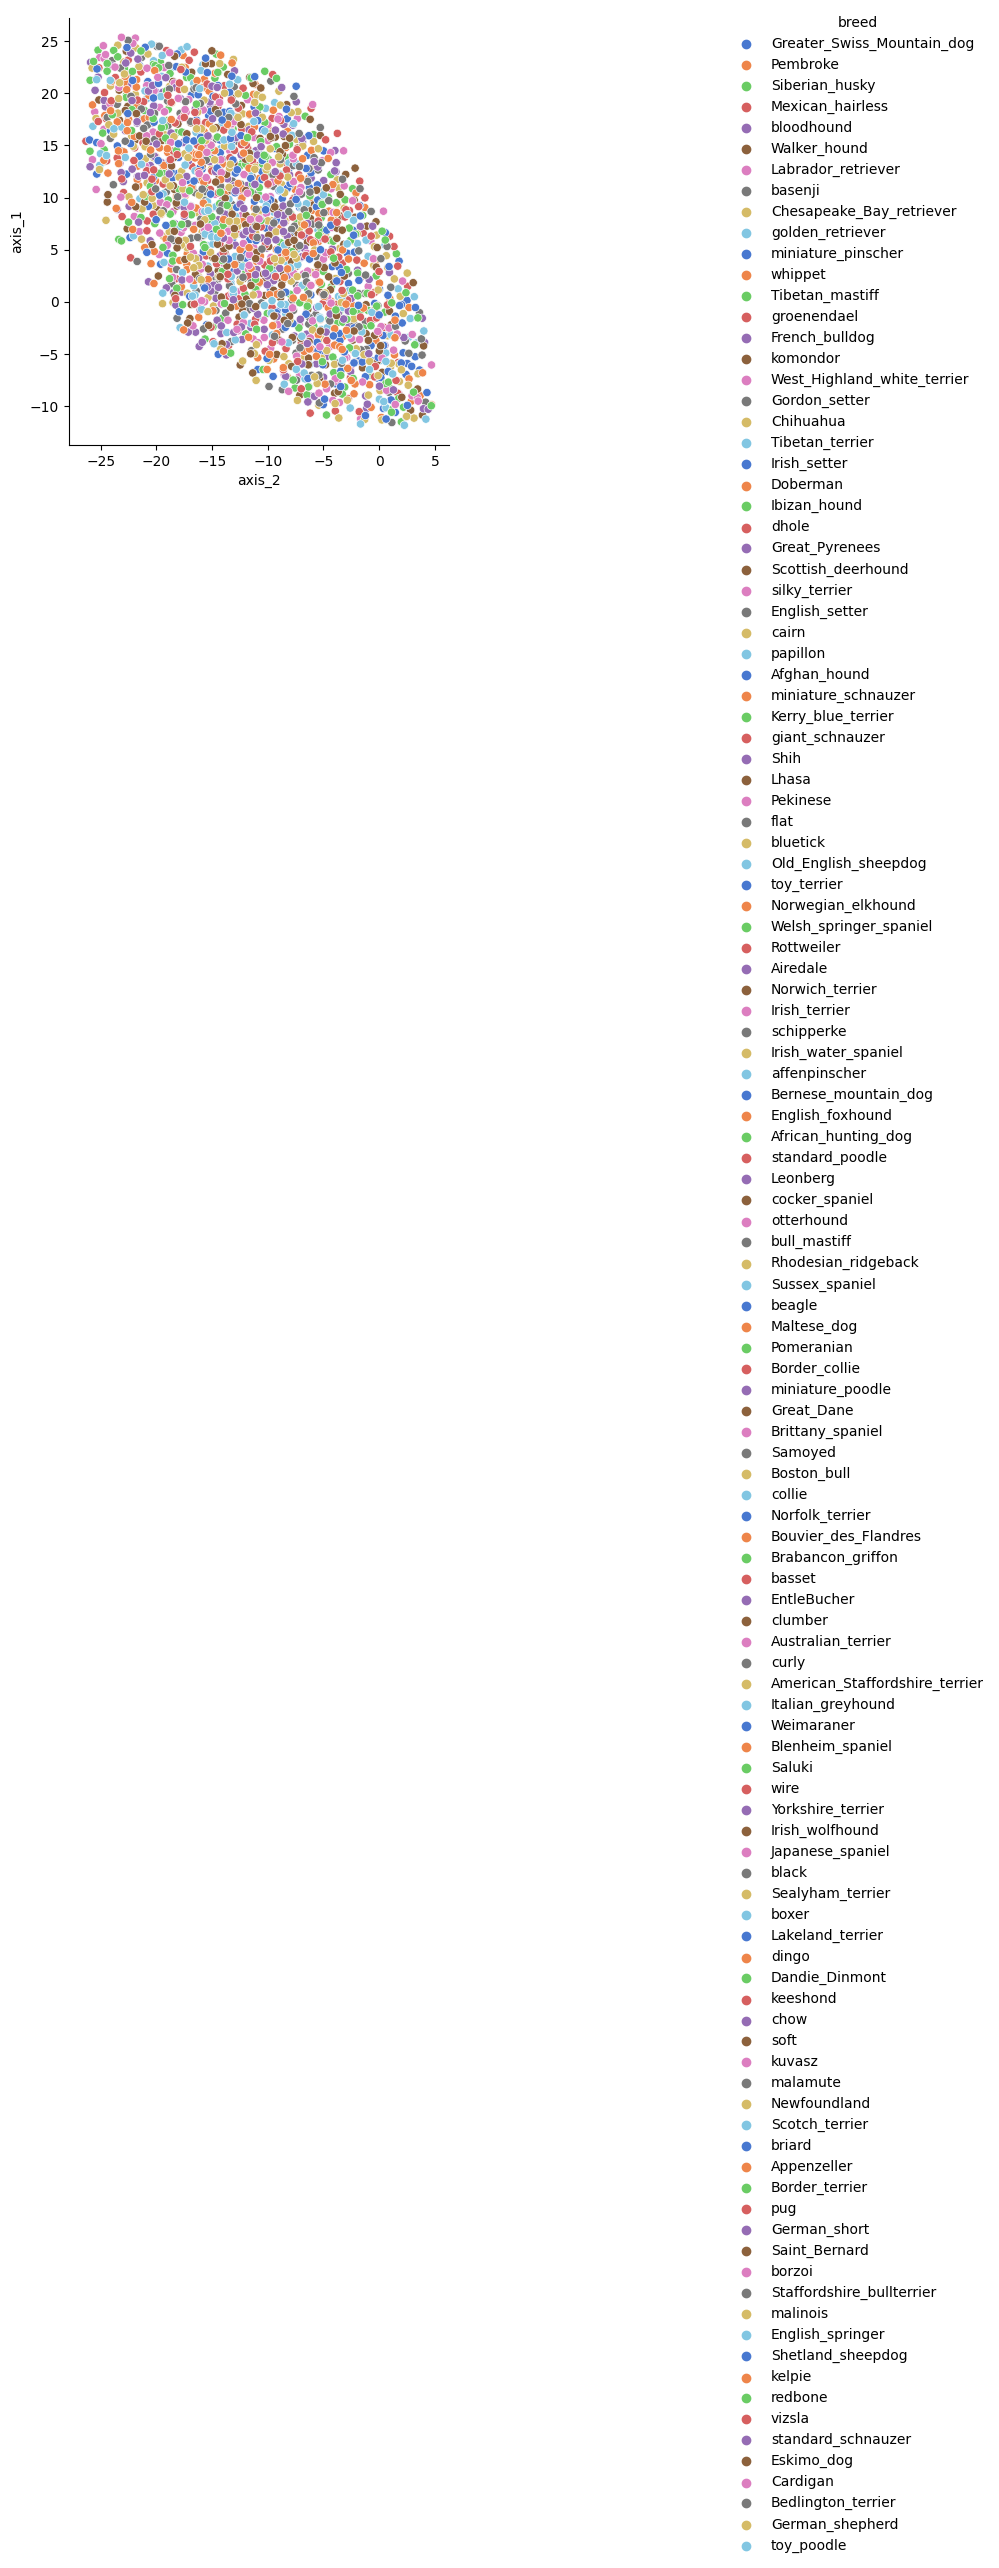

In [ ]:
#plotting the umap embeddings using seaborn relplot
g = sns.relplot(x='axis_2', y='axis_1', hue='breed', data=df, palette="muted")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

###<font color=3ede8e> What is t-SNE?</font>
t-distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction algorithm that is widely used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D.

The main idea behind t-SNE is to map the high-dimensional data points to a lower-dimensional space while preserving the structure of the original data as much as possible. It uses a probabilistic approach to model the similarity between data points in both the high-dimensional and low-dimensional spaces.

The algorithm starts by calculating pairwise similarities between data points in the high-dimensional space using Gaussian kernels. It then defines a similar set of pairwise probabilities between the same data points in the low-dimensional space. The goal is to optimize these probabilities in such a way that similar data points in the high-dimensional space are represented by nearby points in the low-dimensional space.

To achieve this, t-SNE minimizes the Kullback-Leibler divergence between the two sets of pairwise probabilities. It does so by using gradient descent optimization to iteratively adjust the positions of the data points in the lower-dimensional space, aiming to find an arrangement that best represents the underlying structure of the data.

One important characteristic of t-SNE is that it tends to preserve both global and local structures in the data. This means that nearby points in the high-dimensional space are likely to remain close to each other in the low-dimensional space, while the overall arrangement of the points reflects the overall structure of the data.

t-SNE is particularly useful for visualizing high-dimensional data, as it can reveal clusters, patterns, and relationships that may not be easily discernible in the original data space. However, it is computationally intensive and may require careful parameter tuning depending on the specific dataset and desired visualization.

In [ ]:
#Defining the TSNE function and setting its parameters and then calling fit transform with the embedding results passed to it using sklearn library

"""
The hyperparameters:
# - n_components=2: Specifies the number of dimensions in the embedded space. In this case, the data will be transformed into a 2-dimensional space.
# - learning_rate='auto': Determines the step size for the optimization process. The 'auto' value automatically chooses an appropriate learning rate based on the input data.
# - init='pca': Specifies the initialization method for the embedding. It uses the principal component analysis (PCA) technique to effectively initialize the embedding.
# - perplexity=100: Controls the balance between preserving local and global structure in the embedding. Higher perplexity values generally result in better preservation of global structure, but can sacrifice local details.
# - early_exaggeration=20: Controls how tight the embedding is initially. Higher values can lead to a more spread-out embedding.

"""

X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=100, early_exaggeration=20).fit_transform(_results)

In [ ]:
#Turning the lower dimensional embedding into a dataframe
_df = pd.DataFrame(X_embedded)
_df['breed'] = results['breed']

In [ ]:
_df.rename({0: 'axis_1', 1: 'axis_2'}, inplace=True, axis=1)

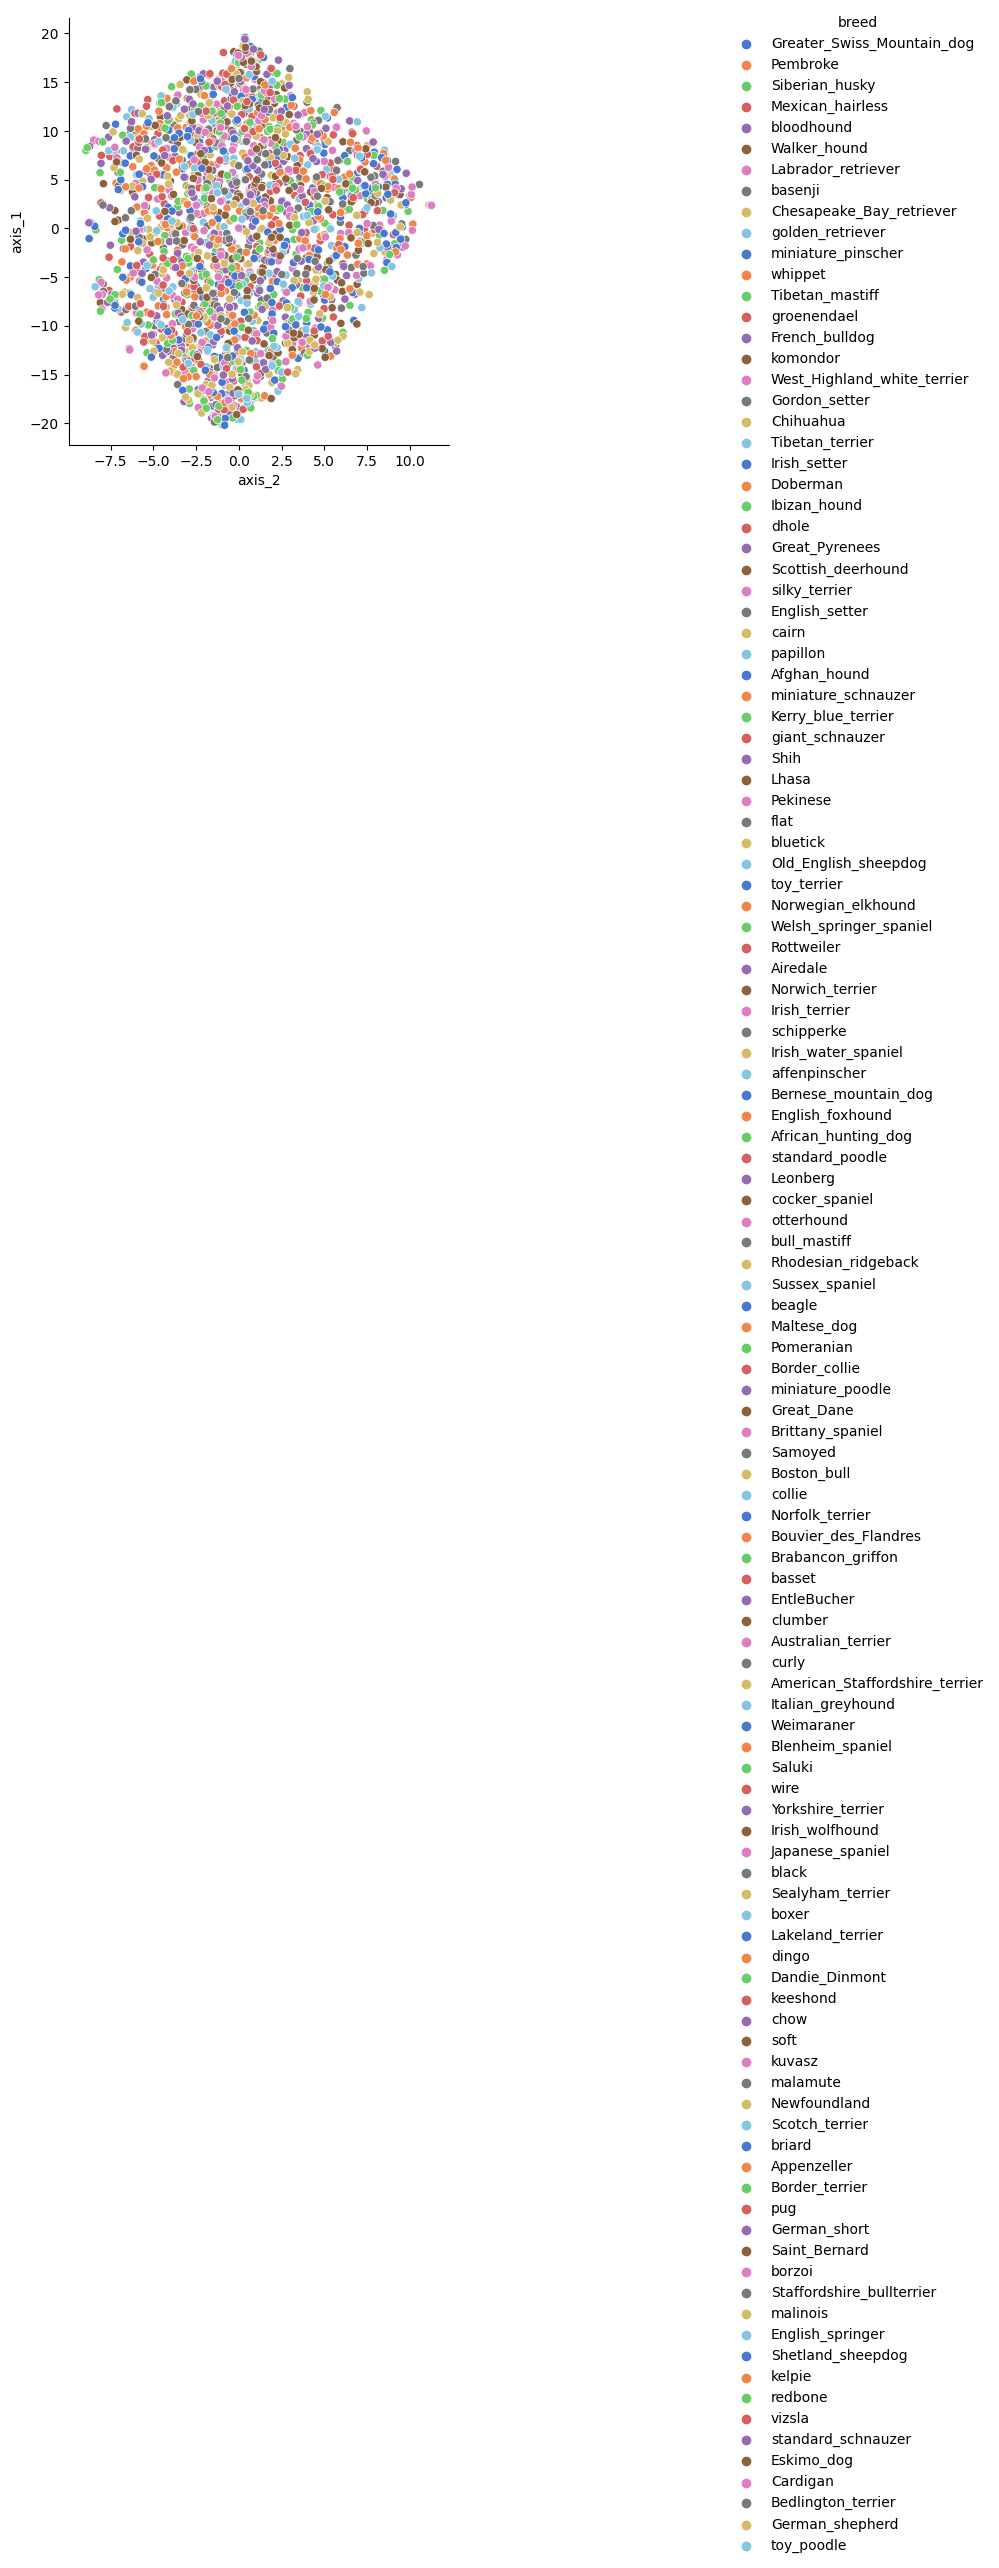

In [ ]:
#Plotting the lower dimensional embedding using seaborn's relplot
g = sns.relplot(x='axis_2', y='axis_1', hue='breed', data=_df, palette="muted")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))



---



# Training clustering models on the autoencoder embeddings


### <font color=3ede8e>Spectral Clustering</font>
We used the `SpectralClustering` model in the scikit-learn library which is an unsupervised learning algorithm used for clustering. This clustering algorithm is used to group data points based on their similarity. It operates by creating a similarity graph, where data points are represented as nodes connected by edges. Spectral clustering then uses spectral decomposition techniques, such as eigenvalues and eigenvectors, to partition the similarity graph into clusters. This approach is effective for discovering clusters in data that may not be linearly separable in the original feature space and has applications in image segmentation, social network analysis, and document clustering, among others.


In [ ]:
#Defining a the clustering model and fitting it to our embeddings
clustering = SpectralClustering(n_clusters=10, assign_labels='discretize', random_state=0, n_neighbors=30).fit(_results)

In [ ]:
results['cluster'] = clustering.labels_

In [ ]:
results[results['breed']=='Chihuahua']

0         1         2         3         4         5         6  \
20   -2.704392 -0.986030  0.238848  3.018597  4.038461  1.477289  2.635298   
283  -2.196117  0.116188 -0.043014  2.624908  3.070864  1.474150  0.882572   
393  -2.729783 -0.563194 -0.115888  3.662252  4.640069  1.047455  1.747344   
521  -2.035259 -0.257084  0.508513  2.456550  5.000343  1.637181  1.264303   
683  -4.179278  0.404439  0.102549  5.014229  6.002481  1.890592  2.591307   
843   0.198334 -0.396927 -0.105912  0.266693  0.170017  0.285067 -0.105552   
844  -1.931163 -0.695215  0.947000  2.247382  3.992524  1.156578  1.490813   
862  -1.875307 -1.746921  0.456902  2.651975  3.225972  0.896724  0.712294   
905  -3.868791 -0.833669  0.286921  5.144220  5.511075  1.838710  2.797049   
1059 -1.263747 -0.650717  0.650125  1.769580  2.361360  1.108923  0.977444   
1277 -1.553596  1.032096  0.318165  5.104852  4.236724  1.783100  2.500635   
1291 -2.777422 -0.820212 -0.842605  5.409274  5.108984  0.801908  2.130266   
1384 -4.072013  0.484327 -0.214493  5.920311  5.787239  0.964937  2.745829   
1502 -4.448657 -0.615786  0.429338  6.560330  6.408005  2.130344  3.313586   
1997 -3.124004  0.579859  0.599996  3.295710  4.227144  1.354081  1.364105   

             7         8         9  ...        56        57        58  \
20    3.795494  1.674318 -4.310384  ... -2.822289  1.899870 -3.351578   
283   2.350967  1.884632 -2.410389  ... -2.036600  2.579576 -2.062969   
393   3.771305  2.341953 -3.283856  ... -3.195418  3.082430 -2.341943   
521   2.818627  2.003128 -2.709161  ... -3.482636  4.261556 -1.896254   
683   4.227548  2.286494 -4.373591  ... -4.164758  4.331182 -4.312273   
843   0.400164  0.370862 -0.125511  ...  0.609062  0.032409 -0.322478   
844   2.890014  1.864077 -2.909173  ... -2.331094  2.330553 -1.966913   
862   2.873728  1.457448 -3.066231  ... -2.377581  2.050532 -3.744871   
905   3.973769  2.112330 -4.933774  ... -2.130622  3.572898 -5.188697   
1059  2.002582  0.591815 -1.958907  ... -0.696921  0.741259 -2.181349   
1277  2.158805  0.375482 -2.705569  ... -1.288039  1.226688 -3.061359   
1291  4.453760  2.150984 -4.097972  ... -2.543200  4.007219 -3.252813   
1384  2.369904  0.451917 -3.183826  ... -3.325199  2.550726 -2.794842   
1502  5.677623  3.578935 -4.677118  ... -4.387433  5.083799 -5.625486   
1997  2.009928  1.498025 -2.527313  ... -2.656338  2.648674 -3.548308   

            59        60        61        62        63      breed  cluster  
20   -1.096397 -0.347822  1.618491  0.970203  5.627984  Chihuahua        0  
283  -1.900606 -0.669110  0.581148  0.615926  3.800777  Chihuahua        6  
393  -2.563097 -0.660408  1.256893  0.329802  5.726764  Chihuahua        0  
521  -3.798872 -1.592817  2.434292  1.760206  4.921332  Chihuahua        6  
683  -2.530998 -1.162846  2.333731  0.565357  7.841900  Chihuahua        0  
843  -0.314656 -0.022994 -0.353765  0.024537  0.249813  Chihuahua        8  
844  -1.459962 -0.483553  1.232194  0.355980  4.552901  Chihuahua        6  
862  -1.323631  0.558295  1.171766  0.354588  4.020053  Chihuahua        6  
905  -3.110498 -1.113944  2.109412  0.317426  7.936536  Chihuahua        0  
1059 -1.088596 -0.210048  0.904914 -0.200912  2.709400  Chihuahua        6  
1277 -1.139244 -2.495512  0.898213 -0.478652  5.455560  Chihuahua        0  
1291 -2.734995  0.447223  1.629144  0.316057  6.514109  Chihuahua        0  
1384 -0.997667 -1.505051  1.015584  0.483936  6.737475  Chihuahua        0  
1502 -2.920258 -0.288630  2.624579 -0.297772  9.120078  Chihuahua        4  
1997 -0.977259 -1.016137  1.549504  0.723533  4.114306  Chihuahua        0  

[15 rows x 66 columns]

In [ ]:
# These breeds blong to the same cluster so ideally they should be similar
results[results['cluster']==0]['breed'].value_counts()

Scottish_deerhound      29
Afghan_hound            26
whippet                 24
Bernese_mountain_dog    22
Japanese_spaniel        22
                        ..
vizsla                   6
groenendael              6
Cardigan                 6
Pekinese                 5
Sussex_spaniel           5
Name: breed, Length: 120, dtype: int64

### <font color=3ede8e>K-nearest neighbors (KNN)</font>
We used the `NearestNeighbors` model in scikit-learn which is an unsupervised learning algorithm that can be used for finding k-nearest neighbors of a given data point. It is based on the concept of nearest neighbors search, which allows finding the most similar points to a particular data point based on a chosen distance metric.

In [ ]:
#Defining and training a knn model on our embeddings
nbrs = NearestNeighbors(n_neighbors=20).fit(_results)

In [ ]:
distances, indices = nbrs.kneighbors(_results)

In [ ]:
# These two embedding vectors are closest
results['breed'][0], results['breed'][653]

('Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog')

In [ ]:
# These two embedding vectors are closest
results['breed'][1], results['breed'][640]

('Pembroke', 'Scottish_deerhound')